In [ ]:
!pip install imbalanced-learn openpyxl librosa joblib --quiet

In [ ]:
import os, ast, joblib, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from google.colab import drive
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_excel("/content/sample_data/full_balanced_dataset_merged.xlsx")
df.columns = [col.strip().lower() for col in df.columns]
df.dropna(subset=["student mfcc", "teacher mfcc", "labels"], inplace=True)

def parse_mfcc(s):
    try: return np.array(ast.literal_eval(s))
    except: return np.array([])

df["student mfcc"] = df["student mfcc"].apply(parse_mfcc)
df["teacher mfcc"] = df["teacher mfcc"].apply(parse_mfcc)
df = df[(df["student mfcc"].apply(len) > 0) & (df["teacher mfcc"].apply(len) > 0)]

X_raw = np.stack([np.concatenate([s, t]) for s, t in zip(df["student mfcc"], df["teacher mfcc"])]).astype(np.float32)
y_raw = df["labels"].str.strip()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)


In [ ]:
input_dim = X_scaled.shape[1]
inp = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inp)
x = Dense(64, activation='relu')(x)
bottleneck = Dense(16, activation='relu')(x)
x = Dense(64, activation='relu')(bottleneck)
x = Dense(128, activation='relu')(x)
out = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=30, batch_size=32, verbose=0)

encoder_model = Model(inp, bottleneck)
X_compressed = encoder_model.predict(X_scaled)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
input_dim = X_scaled.shape[1]
inp = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inp)
x = Dense(64, activation='relu')(x)
bottleneck = Dense(16, activation='relu')(x)
x = Dense(64, activation='relu')(bottleneck)
x = Dense(128, activation='relu')(x)
out = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=30, batch_size=32, verbose=0)

encoder_model = Model(inp, bottleneck)
X_compressed = encoder_model.predict(X_scaled)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    def metrics(y_true, y_pred, dataset):
        print(f"\n {title} ({dataset})")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
        print("Recall:", recall_score(y_true, y_pred, average='weighted'))
        print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({dataset})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    metrics(y_train, y_train_pred, "Train")
    metrics(y_test, y_pred, "Test")



========= 🔀 Split: 80-20 =========
Random Forest (Without SMOTE)

 RF 80-20 No SMOTE (Train)
Accuracy: 0.9954337899543378
Precision: 0.9954475059312552
Recall: 0.9954337899543378
F1 Score: 0.9954359941400991


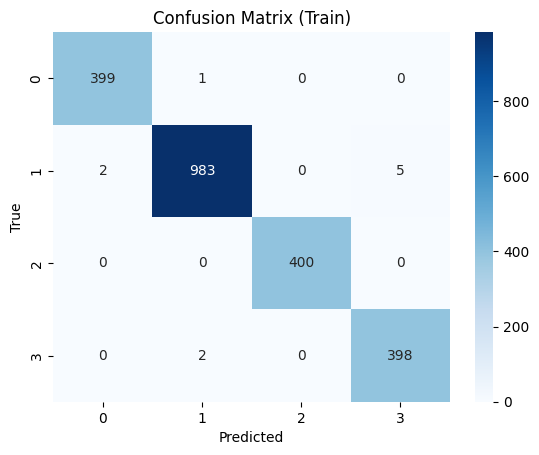


 RF 80-20 No SMOTE (Test)
Accuracy: 0.8686131386861314
Precision: 0.8666994186703186
Recall: 0.8686131386861314
F1 Score: 0.8664474651773377


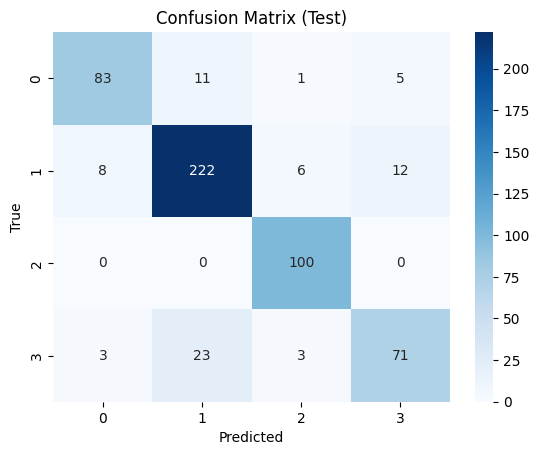

Random Forest (With SMOTE)

 RF 80-20 SMOTE (Train)
Accuracy: 0.9974747474747475
Precision: 0.9974856108500725
Recall: 0.9974747474747475
F1 Score: 0.9974729301423298


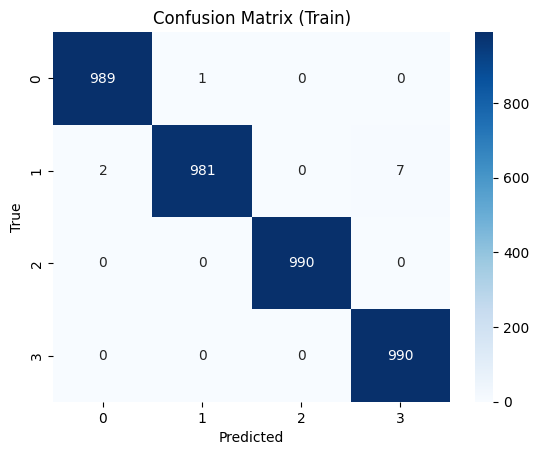


 RF 80-20 SMOTE (Test)
Accuracy: 0.8759124087591241
Precision: 0.8799452511099045
Recall: 0.8759124087591241
F1 Score: 0.876204630621786


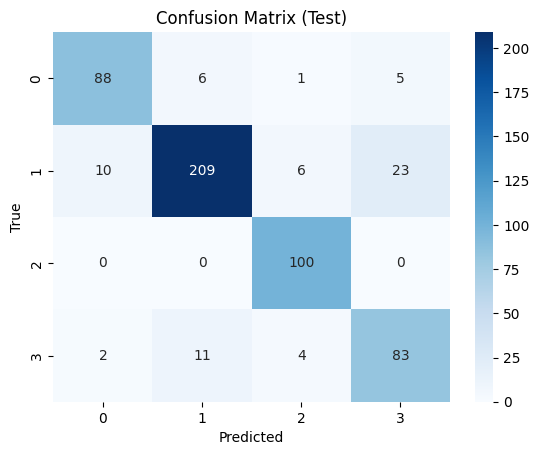


========= 🔀 Split: 70-30 =========
Random Forest (Without SMOTE)

 RF 70-30 No SMOTE (Train)
Accuracy: 0.9958246346555324
Precision: 0.9958269411231311
Recall: 0.9958246346555324
F1 Score: 0.9958237081030232



 RF 70-30 No SMOTE (Test)
Accuracy: 0.8613138686131386
Precision: 0.8589087394400291
Recall: 0.8613138686131386
F1 Score: 0.8588452997674196


Random Forest (With SMOTE)

 RF 70-30 SMOTE (Train)
Accuracy: 0.9976905311778291
Precision: 0.9976918429972094
Recall: 0.9976905311778291
F1 Score: 0.9976891900551069


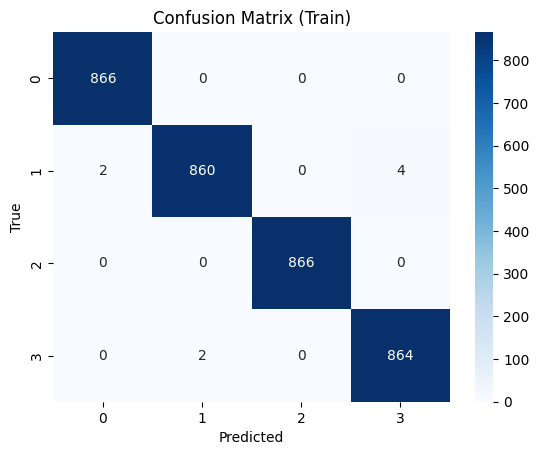


 RF 70-30 SMOTE (Test)
Accuracy: 0.8600973236009732
Precision: 0.863225368668452
Recall: 0.8600973236009732
F1 Score: 0.8601016436615301



========= 🔀 Split: 60-40 =========
Random Forest (Without SMOTE)

 RF 60-40 No SMOTE (Train)
Accuracy: 0.9957369062119367
Precision: 0.9957361112161207
Recall: 0.9957369062119367
F1 Score: 0.9957357998049041


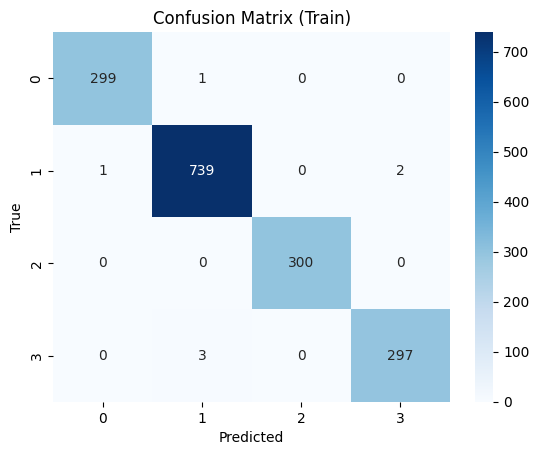


 RF 60-40 No SMOTE (Test)
Accuracy: 0.8558394160583942
Precision: 0.8536099834568086
Recall: 0.8558394160583942
F1 Score: 0.8519017170433226


Random Forest (With SMOTE)

 RF 60-40 SMOTE (Train)
Accuracy: 0.9976415094339622
Precision: 0.9976442009106176
Recall: 0.9976415094339622
F1 Score: 0.9976408200498604



 RF 60-40 SMOTE (Test)
Accuracy: 0.8494525547445255
Precision: 0.8489095645300446
Recall: 0.8494525547445255
F1 Score: 0.848628394897941


In [ ]:
# === Run across splits ===
splits = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
for train_size, test_size in splits:
    print(f"\n========= 🔀 Split: {int(train_size*100)}-{int(test_size*100)} =========")
    X_train, X_test, y_train, y_test = train_test_split(X_compressed, y, test_size=test_size, stratify=y, random_state=42)

    print("Random Forest (Without SMOTE)")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    evaluate_model(model, X_train, y_train, X_test, y_test, f"RF {int(train_size*100)}-{int(test_size*100)} No SMOTE")

    print("Random Forest (With SMOTE)")
    X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
    evaluate_model(model, X_train_sm, y_train_sm, X_test, y_test, f"RF {int(train_size*100)}-{int(test_size*100)} SMOTE")

In [ ]:
from google.colab import drive
import joblib, os
from sklearn.ensemble import RandomForestClassifier

# Mount Google Drive
drive.mount('/content/drive')

# Save directory
save_dir = "/content/drive/MyDrive/TeacherPredictionModels"
os.makedirs(save_dir, exist_ok=True)

# Train on full data with SMOTE
X_train_full, y_train_full = SMOTE(random_state=42).fit_resample(X_compressed, y)
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train_full, y_train_full)

# Save model & artifacts
joblib.dump(final_model, f"{save_dir}/rf_final_model.pkl")
joblib.dump(scaler, f"{save_dir}/rf_scaler.pkl")
joblib.dump(label_encoder, f"{save_dir}/rf_label_encoder.pkl")
joblib.dump(encoder_model, f"{save_dir}/rf_encoder_model.pkl")

print(" Random Forest model and artifacts saved to:", save_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Random Forest model and artifacts saved to: /content/drive/MyDrive/TeacherPredictionModels


In [ ]:
import numpy as np
np.complex = complex

import librosa
import joblib

# Load saved models
scaler = joblib.load("/content/drive/MyDrive/TeacherPredictionModels/rf_scaler.pkl")
label_encoder = joblib.load("/content/drive/MyDrive/TeacherPredictionModels/rf_label_encoder.pkl")
final_model = joblib.load("/content/drive/MyDrive/TeacherPredictionModels/rf_final_model.pkl")
encoder_model = joblib.load("/content/drive/MyDrive/TeacherPredictionModels/rf_encoder_model.pkl")

# MFCC extraction
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc.mean(axis=1)

# Input audio files
student_audio = "/content/sample_data/148_s_26.mp3"
teacher_audio = "/content/sample_data/148_t_26.mp3"

student_mfcc = extract_mfcc(student_audio)
teacher_mfcc = extract_mfcc(teacher_audio)

combined = np.concatenate([student_mfcc, teacher_mfcc]).reshape(1, -1)
scaled = scaler.transform(combined)
compressed = encoder_model.predict(scaled)

# Predict
prediction = final_model.predict(compressed)[0]
label = label_encoder.inverse_transform([prediction])[0]

print(f" Predicted Teacher Response: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
 Predicted Teacher Response: enquiry
